In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
sns.set_style("ticks")
import tikzplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
# import torch
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from allpairspy import AllPairs

# from NAS.search_space import create_search_space, SearchInstance

# torch.manual_seed(0)
np.random.seed(0)

path_results = Path(os.path.expandvars('$WORK/semantics/results/domains'))
seeds = 10

In [2]:
# simple case
# exp = '20240112_1548_filtered'
# df = pd.read_csv(path_results / exp / 'results.csv')
# attributes = ['weather', 'color', 'time', 'location']

# complex case
fname = './reference_evaluation_data.csv'
attributes = ['viewpoint', 'weather', 'color', 'time', 'location']
if os.path.exists(fname):
    print('load')
    df = pd.read_csv(fname)
else:
    df = pd.DataFrame()
    for exp in ['20240308_1506_sideview', '20240306_1930_frontview', '20240308_1644_rearview']:
        df = pd.concat((df, pd.read_csv(path_results / exp / 'results.csv')))
    df = df.drop(columns=['id', 'nb_images', 'id_incorrect'])
    df = df.drop(index=df.index[(df['weather'] == 'sunny') & (df['time'] == 'night')])
    df = df.drop(index=df.index[df['location'] == 'in a car'])
    df = df.drop(index=df.index[(df['location'] == 'inside a house') & ((df['weather'] == 'snowing') | (df['weather'] == 'raining') | (df['weather'] == 'foggy'))])
    df = df.reset_index(drop=True)
    df.to_csv(fname)

idx_to_attribute = {a:{i: u for i, u in enumerate(df[a].unique())} for a in attributes}
attribute_to_idx = {a:{u: i for i, u in enumerate(df[a].unique())} for a in attributes}


load


In [3]:
df

,Unnamed: 0,category,viewpoint,color,time,location,weather,accuracy,average_confidence
0,0,dog,side,white,day,at the beach,sunny,0.98,0.778113
1,1,dog,side,white,day,at the beach,snowing,0.94,0.778403
2,2,dog,side,white,day,at the beach,raining,0.86,0.782886
3,3,dog,side,white,day,at the beach,foggy,0.86,0.762626
4,4,dog,side,white,day,in the forest,sunny,0.78,0.766901
...,...,...,...,...,...,...,...,...,...
1027,1027,dog,rear,blue,night,in the desert,raining,0.58,0.722039
1028,1028,dog,rear,blue,night,in the desert,foggy,0.58,0.741651
1029,1029,dog,rear,blue,night,in the mountains,snowing,0.66,0.754282
1030,1030,dog,rear,blue,night,in the mountains,raining,0.46,0.768484


## random choice

In [4]:
acc_history_random = np.zeros((seeds, len(df)))
for seed in range(seeds):

    rnd_subdomains_idx = []
    df_ = df.copy()
    for i in range(len(df)):
        rnd_subdomain = np.random.choice(df_.index, 1, replace=False)
        df_ = df_.drop(index=rnd_subdomain)

        rnd_subdomains_idx.append(rnd_subdomain.item())
    acc_history_random[seed] = df.loc[rnd_subdomains_idx, 'accuracy'].to_numpy()

# combinatorial testing

In [5]:
parameters = [[u for u in df[a].unique()] for a in attributes]

combinatorial_nb_subdomains = np.zeros(0)
combinatorial_acc_avg = np.zeros(0)
combinatorial_acc_std = np.zeros(0)
for n in [2, 3, 4, 5]:
    subdomains_combinatorial = list(AllPairs(parameters, n=n))
    df_combinatorial = df[df[attributes].apply(lambda row: list(row) in subdomains_combinatorial, axis=1)]
    combinatorial_nb_subdomains = np.append(combinatorial_nb_subdomains, len(df_combinatorial['accuracy']))
    combinatorial_acc_avg = np.append(combinatorial_acc_avg, df_combinatorial['accuracy'].mean())

# genetic algo

In [6]:
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(attributes), n_obj=1, xl=[0 for _ in attributes], xu=[len(df[a].unique())-1 for a in attributes], vtype=int)
        self.eval_history = {}

    def _evaluate(self, x, out, *args, **kwargs):
        acc = np.zeros((x.shape[0]))
        for i in range(x.shape[0]):
            if str(x[i]) in self.eval_history.keys():
                # load result
                acc[i] = self.eval_history[str(x[i])]
            else:
                # run evaluation and save result
                idx = df[attributes].apply(lambda row: list(row) == [idx_to_attribute[attributes[j]][x_] for j, x_ in enumerate(x[i])], axis=1)
                if idx.sum() == 1:
                    acc[i] = df.loc[idx, 'accuracy'].item()
                elif idx.sum() == 0:
                    acc[i] = None
                else:
                    raise ValueError('multiple values')
                self.eval_history[str(x[i])] = acc[i]
        # acc = - acc
        out["F"] = acc


acc_history_genetic = []
for seed in range(seeds):
    problem = MyProblem()

    method = GA(pop_size=20,
                sampling=IntegerRandomSampling(),
                crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                eliminate_duplicates=True,
                )

    res = minimize(problem,
                method,
                termination=('n_eval', 100000),
                seed=seed,
                save_history=True,
                )

    acc_history_genetic.append(np.array(list(problem.eval_history.values())))
    acc_history_genetic[seed] = acc_history_genetic[seed][~np.isnan(acc_history_genetic[seed])]
acc_history_genetic = [a[:min([len(a_) for a_ in acc_history_genetic])] for a in acc_history_genetic] # ensure all same size
acc_history_genetic = np.array(acc_history_genetic)

# using predictor

In [7]:
acc_history_predictor = np.zeros((seeds, len(df)))
for seed in range(seeds):
    # initialize
    nb_subdomains_init = 10
    random_idx = np.random.choice(df.index, nb_subdomains_init, replace=False)
    idx_known = [True if i in random_idx else False for i in range(len(df))]
    X = pd.get_dummies(df[attributes], drop_first=True)
    X_known = X[idx_known]
    X_unknown = X[[not(i) for i in idx_known]]
    y_known = df.loc[idx_known, 'accuracy']
    y_unknown = df.loc[[not(i) for i in idx_known], 'accuracy']
    # model = RandomForestRegressor()
    model = Lasso(alpha=0.001)

    for i in range(len(df)-nb_subdomains_init):
        # fit model on known data
        model.fit(X_known, y_known)

        # predict next sample to evaluate
        # y_pred = model.predict(X_unknown)
        # idx_next = y_pred.argmin()
        improv = model.predict(X_unknown) - y_known.min()
        idx_next = improv.argmin()

        # eval chosen (here accuracy is already pre-computed) and save in known dataset
        X_known = pd.concat((X_known, X_unknown.iloc[idx_next].to_frame().T))
        y_known = pd.concat((y_known, pd.Series({y_unknown.index[idx_next]: y_unknown.iloc[idx_next]})))
        X_unknown = X_unknown.drop(X_unknown.index[idx_next])
        y_unknown = y_unknown.drop(y_unknown.index[idx_next])
    acc_history_predictor[seed] = y_known.to_numpy()

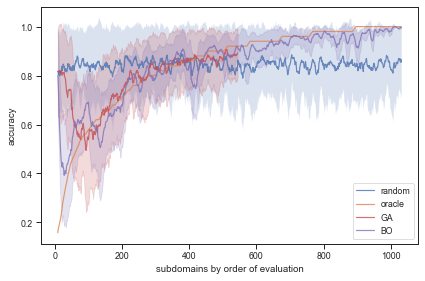

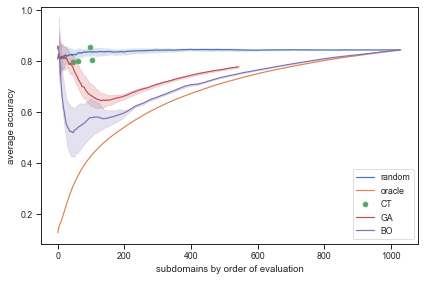

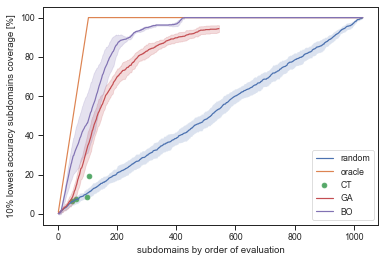

In [8]:
plt.figure()
window_size = 10
# references
plt.plot(pd.Series(acc_history_random.mean(0)).rolling(window=window_size).mean(), alpha=0.8, label='random')
plt.fill_between(df.index,
    pd.Series(acc_history_random.mean(0)).rolling(window=window_size).mean()-pd.Series(acc_history_random.std(0)).rolling(window=window_size).mean(), 
    pd.Series(acc_history_random.mean(0)).rolling(window=window_size).mean()+pd.Series(acc_history_random.std(0)).rolling(window=window_size).mean(),
    alpha=0.2)
acc_history_oracle = df['accuracy'].sort_values().to_numpy()
plt.plot(pd.Series(acc_history_oracle).rolling(window=window_size).mean(), alpha=0.8, label='oracle')
# genetic algo
plt.plot(pd.Series(acc_history_genetic.mean(0)).rolling(window=window_size).mean(), alpha=0.8, color='C3', label='GA')
plt.fill_between(np.arange(acc_history_genetic.shape[1]),
    pd.Series(acc_history_genetic.mean(0)).rolling(window=window_size).mean()-pd.Series(acc_history_genetic.std(0)).rolling(window=window_size).mean(), 
    pd.Series(acc_history_genetic.mean(0)).rolling(window=window_size).mean()+pd.Series(acc_history_genetic.std(0)).rolling(window=window_size).mean(),
    alpha=0.2, color='C3')
# predictor
# acc_history_predictor = y_known.to_numpy()
plt.plot(pd.Series(acc_history_predictor.mean(0)).rolling(window=window_size).mean(), alpha=0.8, color='C4', label='BO')
plt.fill_between(df.index,
    pd.Series(acc_history_predictor.mean(0)).rolling(window=window_size).mean()-pd.Series(acc_history_predictor.std(0)).rolling(window=window_size).mean(), 
    pd.Series(acc_history_predictor.mean(0)).rolling(window=window_size).mean()+pd.Series(acc_history_predictor.std(0)).rolling(window=window_size).mean(),
    alpha=0.2, color='C4')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('subdomains by order of evaluation')
plt.tight_layout()
tikzplotlib.save('accuracy.tikz', axis_height='6cm', axis_width='8cm')



plt.figure()
start = 3
cum_acc_history_random = np.cumsum(acc_history_random, axis=1)/np.arange(1, len(df)+1)
cum_acc_history_predictor = (np.cumsum(acc_history_predictor, axis=1)/np.arange(1, len(df)+1))
cum_acc_history_genetic = (np.cumsum(acc_history_genetic, axis=1)/np.arange(1, acc_history_genetic.shape[1]+1))
# references
plt.plot(cum_acc_history_random.mean(0)[start:], label='random')
plt.fill_between(np.arange(len(df))[start:], 
    cum_acc_history_random.mean(0)[start:]-cum_acc_history_random.std(0)[start:], 
    cum_acc_history_random.mean(0)[start:]+cum_acc_history_random.std(0)[start:],
    alpha=0.2)
plt.plot((np.cumsum(acc_history_oracle)/np.arange(1, len(df)+1))[start:], label='oracle')
# combinatorial
plt.scatter(combinatorial_nb_subdomains, combinatorial_acc_avg, color='C2', label='CT')
# genetic algo
plt.plot(cum_acc_history_genetic.mean(0)[start:], color='C3', label='GA')
plt.fill_between(np.arange(cum_acc_history_genetic.shape[1])[start:], 
    cum_acc_history_genetic.mean(0)[start:]-cum_acc_history_genetic.std(0)[start:], 
    cum_acc_history_genetic.mean(0)[start:]+cum_acc_history_genetic.std(0)[start:],
    alpha=0.2, color='C3')
# predictor
plt.plot(cum_acc_history_predictor.mean(0)[start:], color='C4', label='BO')
plt.fill_between(np.arange(len(df))[start:], 
    cum_acc_history_predictor.mean(0)[start:]-cum_acc_history_predictor.std(0)[start:], 
    cum_acc_history_predictor.mean(0)[start:]+cum_acc_history_predictor.std(0)[start:],
    alpha=0.2, color='C4')
plt.legend()
plt.ylabel('average accuracy')
plt.xlabel('subdomains by order of evaluation')
plt.tight_layout()
tikzplotlib.save('avg_accuracy.tikz', axis_height='6cm', axis_width='8cm')



acc_bottom_10 = df['accuracy'].sort_values().iloc[103] # value (excluded) to be in the bottom 10% of accuracy

combinatorial_nb_subdomains = np.zeros(0)
combinatorial_acc_cov = np.zeros(0)
for n in [2, 3, 4, 5]:
    subdomains_combinatorial = list(AllPairs(parameters, n=n))
    df_combinatorial = df[df[attributes].apply(lambda row: list(row) in subdomains_combinatorial, axis=1)]
    combinatorial_nb_subdomains = np.append(combinatorial_nb_subdomains, len(df_combinatorial['accuracy']))
    combinatorial_acc_cov = np.append(combinatorial_acc_cov, (df_combinatorial['accuracy'] < acc_bottom_10).sum()/1.03)
    
plt.figure()
plt.plot(np.cumsum(acc_history_random < acc_bottom_10, axis=1).mean(0)/1.03, label='random')
plt.fill_between(np.arange(len(df)),
    np.cumsum(acc_history_random < acc_bottom_10, axis=1).mean(0)/1.03-np.cumsum(acc_history_random < acc_bottom_10, axis=1).std(0)/1.03,
    np.cumsum(acc_history_random < acc_bottom_10, axis=1).mean(0)/1.03+np.cumsum(acc_history_random < acc_bottom_10, axis=1).std(0)/1.03,
    alpha=0.2)
plt.plot(np.cumsum(acc_history_oracle < acc_bottom_10)/1.03, label='oracle')
plt.scatter(combinatorial_nb_subdomains, combinatorial_acc_cov, color='C2', label='CT')
plt.plot(np.cumsum(acc_history_genetic < acc_bottom_10, axis=1).mean(0)/1.03, color='C3', label='GA')
plt.fill_between(np.arange(acc_history_genetic.shape[1]),
    np.cumsum(acc_history_genetic < acc_bottom_10, axis=1).mean(0)/1.03-np.cumsum(acc_history_genetic < acc_bottom_10, axis=1).std(0)/1.03,
    np.cumsum(acc_history_genetic < acc_bottom_10, axis=1).mean(0)/1.03+np.cumsum(acc_history_genetic < acc_bottom_10, axis=1).std(0)/1.03,
    alpha=0.2, color='C3')
plt.plot(np.cumsum(acc_history_predictor < acc_bottom_10, axis=1).mean(0)/1.03, color='C4', label='BO')
plt.fill_between(np.arange(len(df)),
    np.cumsum(acc_history_predictor < acc_bottom_10, axis=1).mean(0)/1.03-np.cumsum(acc_history_predictor < acc_bottom_10, axis=1).std(0)/1.03,
    np.cumsum(acc_history_predictor < acc_bottom_10, axis=1).mean(0)/1.03+np.cumsum(acc_history_predictor < acc_bottom_10, axis=1).std(0)/1.03,
    alpha=0.2, color='C4')
plt.xlabel('subdomains by order of evaluation')
plt.ylabel('10% lowest accuracy subdomains coverage [%]')
plt.legend()
tikzplotlib.save('coverage.tikz', axis_height='6cm', axis_width='8cm')


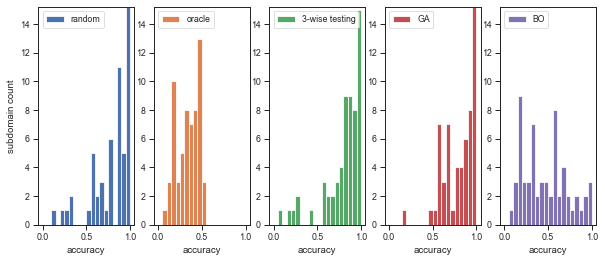

In [9]:
subdomains_combinatorial = list(AllPairs(parameters, n=3))
df_combinatorial = df[df[attributes].apply(lambda row: list(row) in subdomains_combinatorial, axis=1)]

n = len(df_combinatorial)
fig, axs = plt.subplots(1, 5, figsize=(10, 4))
axs[0].hist(acc_history_random[0][:n], bins=20, range=(0,1), color='C0', label='random')
axs[1].hist(acc_history_oracle[:n], bins=20, range=(0,1), color='C1', label='oracle')
axs[2].hist(df_combinatorial['accuracy'], bins=20, range=(0,1), color='C2', label='3-wise testing')
axs[3].hist(acc_history_genetic[0][:n], bins=20, range=(0,1), color='C3', label='GA')
axs[4].hist(acc_history_predictor[0][:n], bins=20, range=(0,1), color='C4', label='BO')
for ax in axs:
    ax.set_ylim(0, 15.2)
    ax.legend(loc='upper left')
    ax.set_xlabel('accuracy')
axs[0].set_ylabel('subdomain count')
tikzplotlib.save('hist_accuracy.tikz', axis_height='4cm', axis_width='5cm')

# Compare predictors

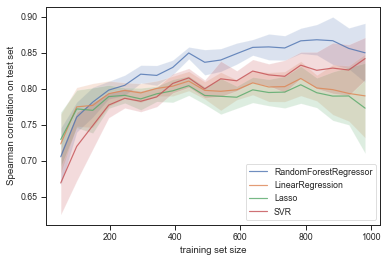

In [10]:
nb_points = 20
dict_spearman = {keys: np.zeros((seeds, nb_points)) for keys in ['RandomForestRegressor', 'LinearRegression', 'Lasso', 'SVR']}
x = np.linspace(50, len(df)-50, nb_points, dtype=int)
for i, nb_subdomains_init in enumerate(x):
    for seed in range(seeds):
        acc_history_predictors = []
        random_idx = np.random.choice(df.index, nb_subdomains_init, replace=False)
        idx_known = [True if i in random_idx else False for i in range(len(df))]
        X = pd.get_dummies(df[attributes], drop_first=True)
        X_known = X[idx_known]
        X_unknown = X[[not(i) for i in idx_known]]
        y_known = df.loc[idx_known, 'accuracy']
        y_unknown = df.loc[[not(i) for i in idx_known], 'accuracy']

        for model in [RandomForestRegressor(), LinearRegression(), Lasso(alpha=0.001), svm.SVR()]:
            model.fit(X_known, y_known)
            y_pred = model.predict(X_unknown)
            dict_spearman[type(model).__name__][seed, i] = spearmanr(y_unknown, y_pred).correlation

plt.figure()
for model in dict_spearman.keys():
    plt.plot(x, dict_spearman[model].mean(0), label=model, alpha=0.8)
    plt.fill_between(x, dict_spearman[model].mean(0)-dict_spearman[model].std(0), dict_spearman[model].mean(0)+dict_spearman[model].std(0), alpha=0.2)
plt.legend()
plt.xlabel('training set size')
plt.ylabel('Spearman correlation on test set')
tikzplotlib.save('spearman.tikz', axis_height='6cm', axis_width='8cm')

# Classifier failures

In [11]:
explore_until = 300

acc_history_predictor = np.zeros((seeds, len(df)))
# initialize
nb_subdomains_init = 10
random_idx = np.random.choice(df.index, nb_subdomains_init, replace=False)
idx_known = [True if i in random_idx else False for i in range(len(df))]
X = pd.get_dummies(df[attributes], drop_first=True)
X_known = X[idx_known]
X_unknown = X[[not(i) for i in idx_known]]
y_known = df.loc[idx_known, 'accuracy']
y_unknown = df.loc[[not(i) for i in idx_known], 'accuracy']
# model = RandomForestRegressor()
model = Lasso(alpha=0.001)

for i in range(explore_until-nb_subdomains_init):
    # fit model on known data
    model.fit(X_known, y_known)

    # predict next sample to evaluate
    # y_pred = model.predict(X_unknown)
    # idx_next = y_pred.argmin()
    improv = model.predict(X_unknown) - y_known.min()
    idx_next = improv.argmin()

    # eval chosen (here accuracy is already pre-computed) and save in known dataset
    X_known = pd.concat((X_known, X_unknown.iloc[idx_next].to_frame().T))
    y_known = pd.concat((y_known, pd.Series({y_unknown.index[idx_next]: y_unknown.iloc[idx_next]})))
    X_unknown = X_unknown.drop(X_unknown.index[idx_next])
    y_unknown = y_unknown.drop(y_unknown.index[idx_next])
df_failures = df.loc[X_known.index]

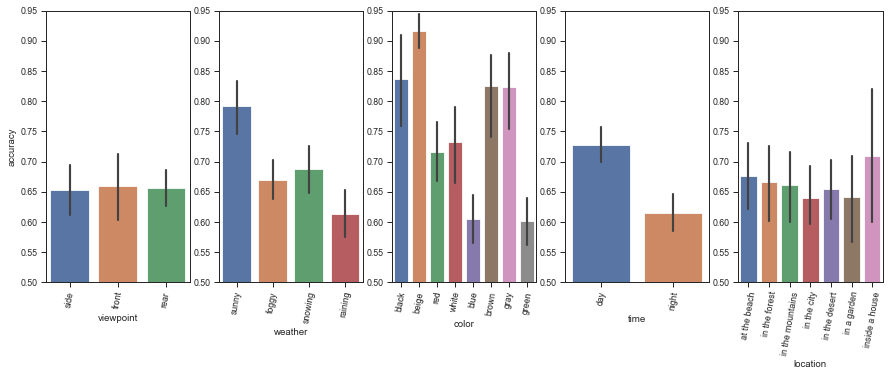

In [12]:
fig, axs = plt.subplots(1, len(attributes), figsize=(15, 5))
for i, attribute in enumerate(attributes):
    sns.barplot(data=df_failures, x=attribute, y='accuracy', ax=axs.flatten()[i])
    axs.flatten()[i].set_ylim(0.5, 0.95)
    if i>0: axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].tick_params(axis='x', rotation=80)
tikzplotlib.save('barplot_accuracy.tikz', axis_height='4cm', axis_width='5cm')


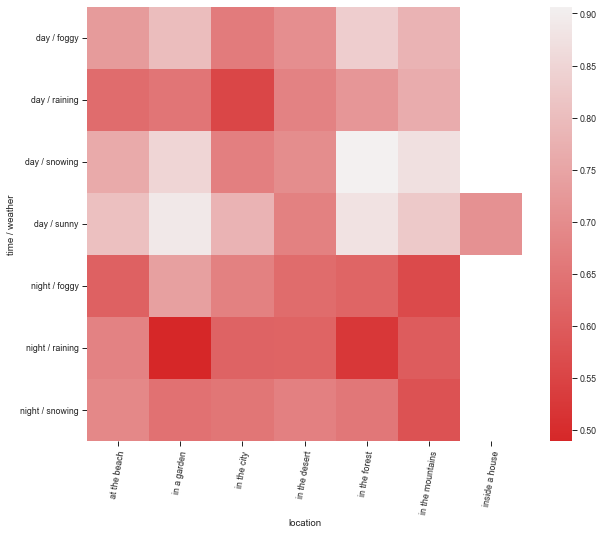

In [13]:
df_failures['time / weather'] = df_failures['time'] + ' / ' + df_failures['weather']
pivot_table = df_failures.pivot_table(values='accuracy', index='time / weather', columns='location', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, square=True, cmap=sns.light_palette("#d62728", reverse=True, as_cmap=True))
plt.tick_params(axis='x', rotation=80)
plt.tick_params(axis='y', rotation=0)

tikzplotlib.save('heatmap_accuracy.tikz', axis_height='8cm', axis_width='8cm')

In [14]:
STOP

NameError: name 'STOP' is not defined

# Neural Architecture Search method

In [ ]:
attribute_to_idx = {a:{u: i for i, u in enumerate(df[a].unique())} for a in attributes}
encodings = torch.empty((len(df), len(attributes)))
for i, a in enumerate(attributes):
    encodings[:, i] = torch.tensor(df[a].apply(lambda row: attribute_to_idx[a][row]).values)

# Sans pré-entrainement
search_space = create_search_space(name='Exemple',
                                    save_filename='search_space.dill',
                                    encodings=encodings,
                                    encoding_to_net=None,
                                    device='cpu')

search_space.preprocess_no_pretraining()


# Fonctions d'éval. Juste pour le test je vais mettre
# la haute fidélité la somme des 3 variables
# et la basse fidélité la somme + une petite perturbation aléatoire
# ça prend une liste de encodings en entrée
# Les costs sont importants juste pour l'affichage (la rapidité de la recherche)
# en NAS je mets le nombre d'epochs dans l'éval à haute et à basse fidélité
idx_to_attribute = {a:{i: u for i, u in enumerate(df[a].unique())} for a in attributes}

def hi_fi_eval(x):
    acc = np.zeros((x.shape[0]))
    for i in range(x.shape[0]):
        # run evaluation and save result
        idx = df[attributes].apply(lambda row: list(row) == [idx_to_attribute[attributes[j]][x_.item()] for j, x_ in enumerate(x[i])], axis=1)
        assert idx.sum() == 1
        acc[i] = df.loc[idx, 'accuracy'].item()
    return 1 - acc
hi_fi_cost = 200

def lo_fi_eval(x):
    return hi_fi_eval(x)
lo_fi_cost = 12

In [ ]:
search_instance = SearchInstance(name='Exemple',
                                    save_filename='search_inst.dill',
                                    search_space_filename='search_space.dill',
                                    hi_fi_eval = hi_fi_eval,
                                    hi_fi_cost = hi_fi_cost,
                                    lo_fi_eval = lo_fi_eval,
                                    lo_fi_cost = lo_fi_cost,
                                    full_evals_update_freq=1, n_full_evals_per_update=1,
                                    part_evals_update_freq=1, n_part_evals_per_update=1,
                                    device='cpu')

search_instance.run_search(eval_budget=int(10))

# ça va sauvegarder à chaque itération. si tu veux reprendre une recherche arrêtée,
# load l'objet SearchInstance directement (avec dill), et lance avec run_search.
# (pas besoin de redéfinir le search space etc..., il va être loadé du fichier)
# with open('test_search_inst.dill', 'rb') as f:
#    s = dill.load(f)

In [ ]:
1 - search_instance.search.full_evals[search_instance.search.full_evals_mask == 1]

In [ ]:
1 - search_instance.search.part_evals[search_instance.search.part_evals_mask == 1]

In [ ]:
search_instance.search.all_configs[search_instance.search.full_evals_mask == 1]

In [ ]:
search_instance.search.all_configs[search_instance.search.part_evals_mask == 1]